/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/2
242/242 ━━━━━━━━━━━━━━━━━━━━ 51s 189ms/step - accuracy: 0.8336 - loss: 0.3436 - val_accuracy: 0.9948 - val_loss: 0.0232
Epoch 2/2
242/242 ━━━━━━━━━━━━━━━━━━━━ 45s 186ms/step - accuracy: 0.9982 - loss: 0.0126 - val_accuracy: 0.9990 - val_loss: 0.0060
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9991 - loss: 0.0048

✅ Test Accuracy: 0.9990


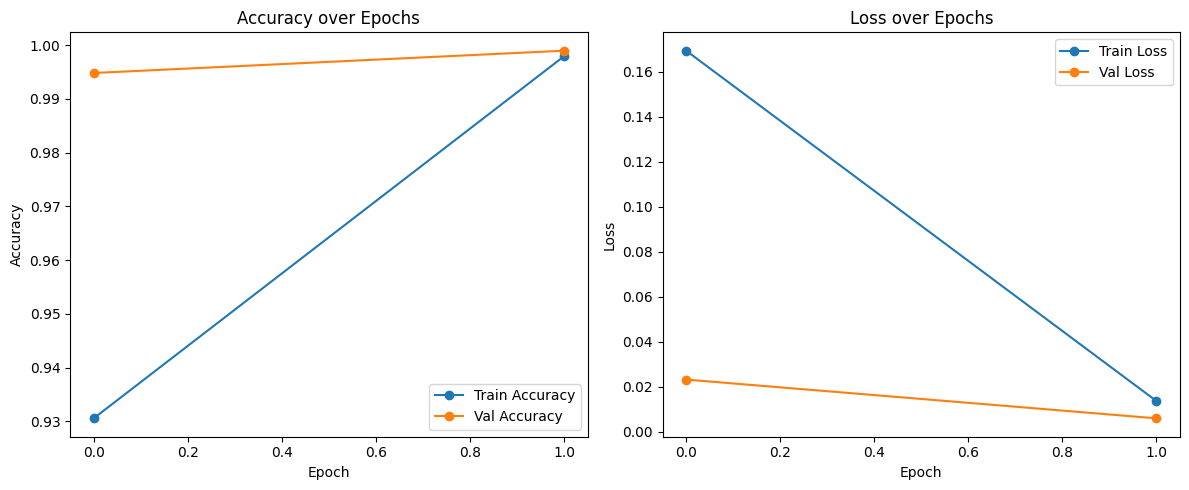

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Load and clean the dataset
df = pd.read_csv('/content/spam.csv', encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'message']

# Upsample spam to balance dataset
ham_df = df[df['label'] == 'ham']
spam_df = df[df['label'] == 'spam']
spam_upsampled = resample(spam_df, replace=True, n_samples=len(ham_df), random_state=42)
balanced_df = pd.concat([ham_df, spam_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# Label encoding
label_encoder = LabelEncoder()
balanced_df['label'] = label_encoder.fit_transform(balanced_df['label'])  # ham=0, spam=1

# Tokenization and padding
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(balanced_df['message'])
sequences = tokenizer.texts_to_sequences(balanced_df['message'])
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Prepare features and labels
X = padded_sequences
y = np.array(balanced_df['label'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the improved LSTM model
vocab_size = len(tokenizer.word_index) + 1

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_test, y_test))

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {accuracy:.4f}")

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [2]:
print(spam_upsampled)
print(balanced_df)

     label                                            message
712   spam              08714712388 between 10am-7pm Cost 10p
3228  spam  Ur cash-balance is currently 500 pounds - to m...
1928  spam  Call from 08702490080 - tells u 2 call 0906635...
737   spam  Hi. Customer Loyalty Offer:The NEW Nokia6650 M...
504   spam  +123 Congratulations - in this week's competit...
...    ...                                                ...
4246  spam  Text PASS to 69669 to collect your polyphonic ...
3673  spam  You have won a Nokia 7250i. This is what you g...
3618  spam  8007 25p 4 Alfie Moon's Children in Need song ...
3499  spam  Dorothy@kiefer.com (Bank of Granite issues Str...
4235  spam  U can WIN å£100 of Music Gift Vouchers every w...

[4825 rows x 2 columns]
      label                                            message
0         0    Mm yes dear look how i am hugging you both. :-P
1         0                  But pls dont play in others life.
2         0          i can call in  &lt;#&

61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step

📊 T-Test: t-statistic = -674.1108, p-value = 0.0000

📈 Z-Test: z-statistic = -674.1108, p-value = 0.0000

🔍 ANOVA: F-statistic = nan, p-value = nan


<ipython-input-5-6c6dad1a3327>:30: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_stat, anova_p = f_oneway(group_1, group_2, group_3)


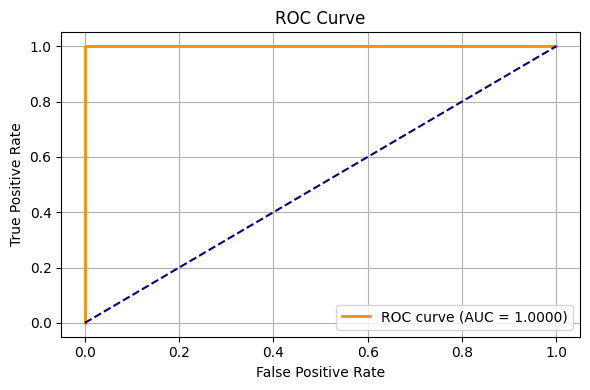


📋 Classification Report:

              precision    recall  f1-score   support

         Ham       1.00      1.00      1.00       975
        Spam       1.00      1.00      1.00       955

    accuracy                           1.00      1930
   macro avg       1.00      1.00      1.00      1930
weighted avg       1.00      1.00      1.00      1930



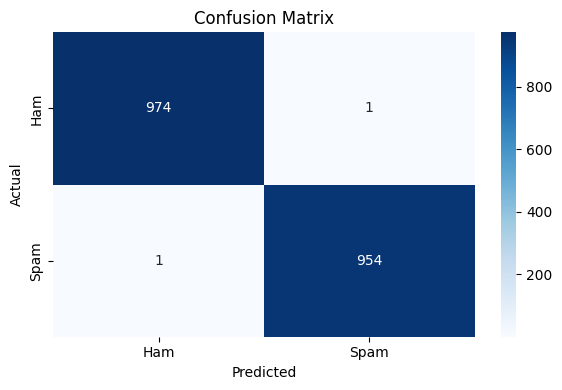


❗ Type I Error (False Positives): 1
❗ Type II Error (False Negatives): 1

📏 Cohen’s D = -30.6919 → very large effect 🎯


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from scipy.stats import ttest_ind, f_oneway
from statsmodels.stats.weightstats import ztest

# Get predicted probabilities
y_pred_probs = model.predict(X_test) # This line is added to get predicted probabilities
# Convert probabilities to binary predictions (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int) # This line is added to get binary predictions

# Flatten predictions
ham_probs = y_pred_probs[y_test == 0].flatten()
spam_probs = y_pred_probs[y_test == 1].flatten()

# ✅ T-Test
t_stat, p_val = ttest_ind(ham_probs, spam_probs)
print(f"\n📊 T-Test: t-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")

# ✅ Z-Test
z_stat, z_p = ztest(ham_probs, spam_probs)
print(f"\n📈 Z-Test: z-statistic = {z_stat:.4f}, p-value = {z_p:.4f}")

# ✅ ANOVA
group_1 = y_pred_probs[(y_pred_probs >= 0.0) & (y_pred_probs < 0.33)].flatten()
group_2 = y_pred_probs[(y_pred_probs >= 0.33) & (y_pred_probs < 0.66)].flatten()
group_3 = y_pred_probs[(y_pred_probs >= 0.66)].flatten()

f_stat, anova_p = f_oneway(group_1, group_2, group_3)
print(f"\n🔍 ANOVA: F-statistic = {f_stat:.4f}, p-value = {anova_p:.4f}")

# ✅ ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Classification Report and Confusion Matrix
cm = confusion_matrix(y_test, y_pred)  # Use y_pred here
print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ✅ Type I and Type II Errors
print(f"\n❗ Type I Error (False Positives): {cm[0][1]}")
print(f"❗ Type II Error (False Negatives): {cm[1][0]}")

# ✅ Bonus: Cohen’s D (effect size for t-test)
def cohens_d(group1, group2):
    diff = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt((np.std(group1, ddof=1) ** 2 + np.std(group2, ddof=1) ** 2) / 2)
    return diff / pooled_std

d = cohens_d(ham_probs, spam_probs)
print(f"\n📏 Cohen’s D = {d:.4f} →", end=" ")

# Effect size interpretation
if abs(d) < 0.2:
    print("small effect")
elif abs(d) < 0.5:
    print("medium effect")
elif abs(d) < 0.8:
    print("large effect")
else:
    print("very large effect 🎯")

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1: Define the preprocessing function
def preprocess_text(text, tokenizer, max_length):
    # Convert text to sequence using the tokenizer
    sequence = tokenizer.texts_to_sequences([text])
    # Pad the sequence to ensure it has the same length as the training data
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    return padded_sequence

# Step 2: Define the prediction function
def predict_spam_or_ham(text, model, tokenizer, max_length):
    # Preprocess the input text
    processed_text = preprocess_text(text, tokenizer, max_length)

    # Predict the label (0: ham, 1: spam)
    prediction = model.predict(processed_text)

    # Interpret the prediction
    if prediction >= 0.5:
        return "Spam"
    else:
        return "Ham"

# Example usage:
# Assume you have the trained `model`, `tokenizer`, and `max_length` from the previous code

test_messages = [
    "WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only."]

for message in test_messages:
    result = predict_spam_or_ham(message, model, tokenizer, max_length)
    print(f"Message: {message}\nPrediction: {result}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Message: WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
Prediction: Spam



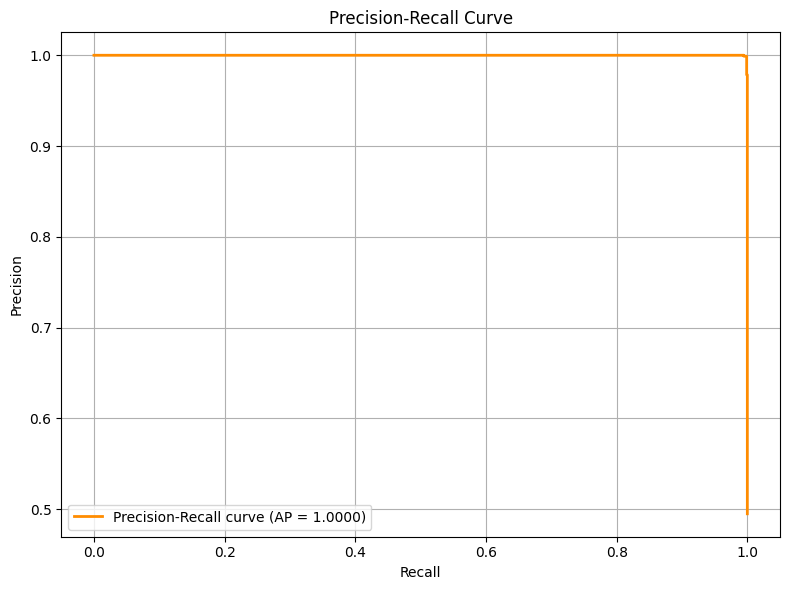

In [9]:
# prompt: precision recall curve

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)

# calculate average precision score
average_precision = average_precision_score(y_test, y_pred_probs)

# plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
